In [2]:
!python -V

Python 3.9.12


see video: https://www.youtube.com/watch?v=iRunifGSHFc&list=PL3MmuxUbc_hIUISrluw_A7wDSmfOhErJK

also get data for jan and feb:
wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.pa
rquet
wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.pa
rquet

In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn import metrics

In [14]:
import os
os.getcwd()


'/workspaces/mlops-zoomcamp/01-intro'

In [16]:
df = pd.read_parquet('./data/green_tripdata_2024-01.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56551 entries, 0 to 56550
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               56551 non-null  int32         
 1   lpep_pickup_datetime   56551 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  56551 non-null  datetime64[ns]
 3   store_and_fwd_flag     53136 non-null  object        
 4   RatecodeID             53136 non-null  float64       
 5   PULocationID           56551 non-null  int32         
 6   DOLocationID           56551 non-null  int32         
 7   passenger_count        53136 non-null  float64       
 8   trip_distance          56551 non-null  float64       
 9   fare_amount            56551 non-null  float64       
 10  extra                  56551 non-null  float64       
 11  mta_tax                56551 non-null  float64       
 12  tip_amount             56551 non-null  float64       
 13  t

In [17]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [22]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
print("RMSE is:")
metrics.mean_squared_error(y_train, y_pred)

RMSE is:


50.15338506134322

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


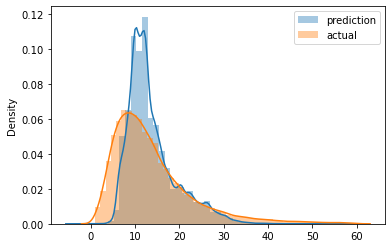

In [23]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [24]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [25]:
df_train = read_dataframe('./data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2024-02.parquet')

In [26]:
len(df_train), len(df_val)

(54373, 51497)

In [27]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [28]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [29]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
print("RMSE is:")
metrics.mean_squared_error(y_val, y_pred)

RMSE is:


35.791707812020626

In [34]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [36]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

metrics.mean_squared_error(y_val, y_pred)

64.4695450468824